In [ ]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses

import os
import numpy as np
import pandas as pd
!pip install pickle5
import pickle5 as pickle
from skimage.transform import resize as sk_resize

     |████████████████████████████████| 256 kB 21.3 MB/s 


In [ ]:
# connect Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# load data
path = '/content/drive/MyDrive/W210/Wafer-Defect-Classification'

with open(f'{path}/WM-clean.pkl', "rb") as fh:
    raw_data = pickle.load(fh)
    
print(f'Raw data shape: {raw_data.shape}')

Raw data shape: (172950, 11)


In [ ]:
# add detection model labels
raw_data['detect_labels'] = raw_data['failureType'].apply(lambda x: 0 if x == 'none' else 1)
raw_data.head()

,waferMap,dieSize,lotName,waferIndex,failureType,encoding,x_,y_,shape,labels,dataset,detect_labels
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,1.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,2.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,3.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",test,0
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,4.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1683.0,lot1,5.0,none,1,45,48,"(45, 48)","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]",train,0


In [ ]:
# resize images to 32x32
# normalize values to range of [0,1]
raw_data['resized_map'] = raw_data.waferMap.apply(lambda x: sk_resize(x/2, [32, 32], order=0, preserve_range=True, anti_aliasing=False))

In [ ]:
# split data into train, dev, and test sets
train = raw_data[raw_data.dataset == 'train'].reset_index(drop=True)
dev = raw_data[raw_data.dataset == 'dev'].reset_index(drop=True)
test = raw_data[raw_data.dataset == 'test'].reset_index(drop=True)
print(f"Train: {len(train)}")
print(f"Dev: {len(dev)}")
print(f"Test: {len(test)}")

Train: 121065
Dev: 25942
Test: 25943


In [ ]:
x_train = np.stack(train['resized_map'])
x_val = np.stack(dev['resized_map'])
x_test = np.stack(test['resized_map'])
x_train.shape

(121065, 32, 32)

In [ ]:
# expand tensor and create dummy dimension at axis 3
# images in greyscale, so no channel dimension
x_train = tf.expand_dims(x_train, axis=3, name=None)
x_val = tf.expand_dims(x_val, axis=3, name=None)
x_test = tf.expand_dims(x_test, axis=3, name=None)
x_train.shape

TensorShape([121065, 32, 32, 1])

In [ ]:
y_train = np.asarray(train['detect_labels'])
y_val = np.asarray(dev['detect_labels'])
y_test = np.asarray(test['detect_labels'])

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(6, 5, activation='tanh', input_shape=x_train.shape[1:]))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(16, 5, activation='tanh'))
model.add(layers.AveragePooling2D(2))
model.add(layers.Activation('sigmoid'))
model.add(layers.Conv2D(120, 5, activation='tanh'))
model.add(layers.Flatten())
model.add(layers.Dense(84, activation='tanh'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         156       
                                                                 
 average_pooling2d (AverageP  (None, 14, 14, 6)        0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 average_pooling2d_1 (Averag  (None, 5, 5, 16)         0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 5, 5, 16)          0

In [ ]:
model.compile(optimizer='adam', loss=losses.sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
history = model.fit(x_train, y_train, batch_size=64, epochs=40, validation_data=(x_val, y_val))

Epoch 1/40
1892/1892 [==============================] - 18s 5ms/step - loss: 0.4226 - accuracy: 0.8520 - val_loss: 0.4187 - val_accuracy: 0.8524
Epoch 2/40
1892/1892 [==============================] - 9s 5ms/step - loss: 0.4200 - accuracy: 0.8525 - val_loss: 0.4218 - val_accuracy: 0.8524
Epoch 3/40
1892/1892 [==============================] - 9s 5ms/step - loss: 0.4198 - accuracy: 0.8525 - val_loss: 0.4201 - val_accuracy: 0.8524
Epoch 4/40
1892/1892 [==============================] - 8s 4ms/step - loss: 0.4201 - accuracy: 0.8525 - val_loss: 0.4192 - val_accuracy: 0.8524
Epoch 5/40
1892/1892 [==============================] - 9s 5ms/step - loss: 0.4202 - accuracy: 0.8525 - val_loss: 0.4186 - val_accuracy: 0.8524
Epoch 6/40
1892/1892 [==============================] - 8s 4ms/step - loss: 0.4199 - accuracy: 0.8525 - val_loss: 0.4191 - val_accuracy: 0.8524
Epoch 7/40
1892/1892 [==============================] - 8s 4ms/step - loss: 0.4200 - accuracy: 0.8525 - val_loss: 0.4186 - val_accuracy

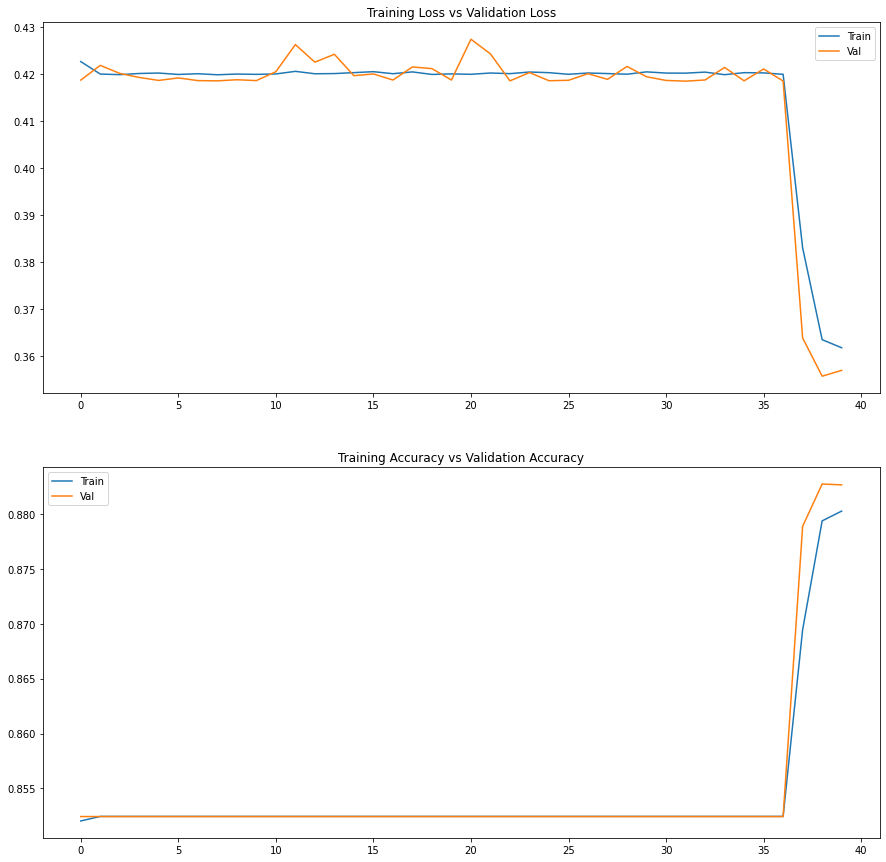

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(15,15))

axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[0].title.set_text('Training Loss vs Validation Loss')
axs[0].legend(['Train', 'Val'])

axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[1].title.set_text('Training Accuracy vs Validation Accuracy')
axs[1].legend(['Train', 'Val'])


In [ ]:
model.evaluate(x_test, y_test)

811/811 [==============================] - 2s 3ms/step - loss: 0.3619 - accuracy: 0.8819


[0.3619253933429718, 0.8819334506988525]